In [135]:
## Import packages
import numpy as np
import os, sys, glob
import skimage.io as io
import multiprocessing as mp
import pickle as pkl
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from scipy import ndimage as ndi
from scipy.signal import find_peaks
from skimage import measure
from skimage.feature import peak_local_max
from skimage.morphology import disk, dilation
import cv2
from skimage.filters import rank
from collections import Counter
from skimage.morphology import dilation, erosion, square
from tqdm import tqdm
import logging

## Example of tracking measures

In [22]:
image = io.imread('data/EV39_last_timestep.tif')
masks = io.imread('data/EV39_last_timestep_mask.tif')
df = pd.read_csv('data/EV39_metrics.csv', index_col=0)
tracks = np.load('data/EV39_tracks.npy')
step_distance = np.load('data/EV39_step_distance.npy')
bg_mask = image == 0

## Manage background from unimaged
logging.info('Threshold')
vals = image.flatten()
vals = vals[vals>0]
bg_val = np.quantile(vals, .05)
image[np.where(image < bg_val)] = bg_val
image = 255 * (image/np.max(image))
image = image.astype(int)

/var/lib/condor/execute/dir_1159735/ipykernel_47493/706930410.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm', 100)


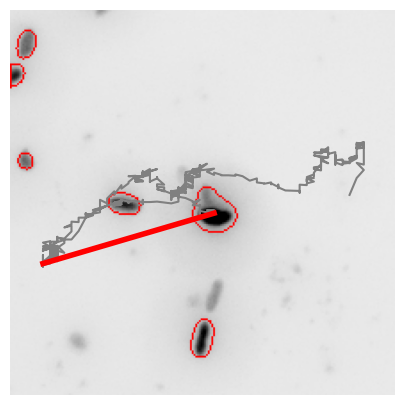

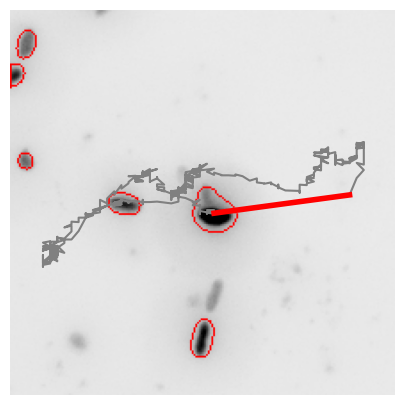

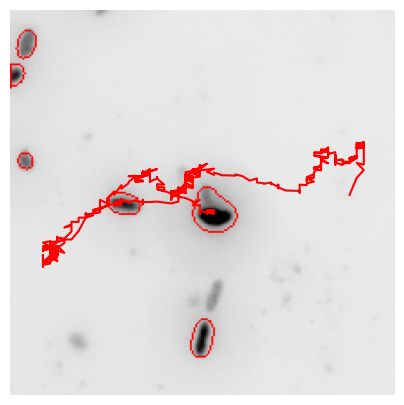

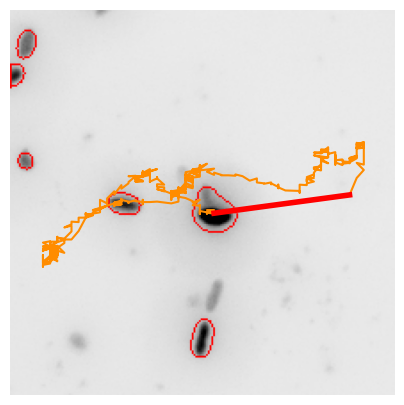

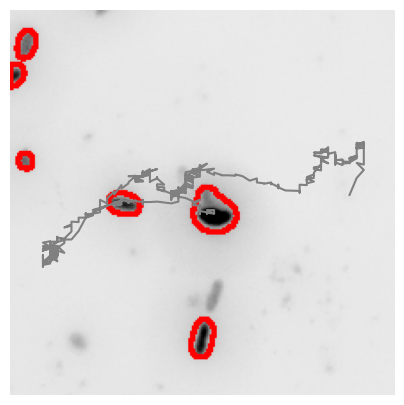

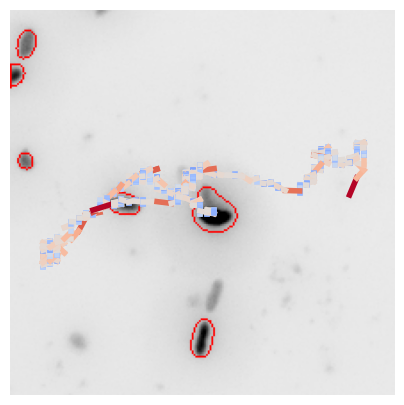

In [69]:
from matplotlib import cm
s = 8

track = tracks[s,:,:]
valid = track[0,:] > 0
track = track[:,valid]
mn = np.min(track, 1).astype(int)
mx = np.max(track, 1).astype(int)
cnt = (mn + mx) / 2
cnt = cnt.astype(int)

r = int(np.max(mx - mn) * .6)

y1 = np.max([cnt[1] - r, 0])
y2 = cnt[1] + r
x1 = np.max([cnt[0] - r, 0])
x2 = cnt[0] + r

im = 255 - image[x1:x2, y1:y2]
m = masks[x1:x2, y1:y2]
contours, hierarchy = cv2.findContours(m.astype('uint8'),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)

label_map = np.repeat(im[:, :, np.newaxis], 3, axis=2).astype('uint8')
for i, contour in enumerate(contours):
    label_map = cv2.drawContours(label_map, [contour], -1, (255,0,0), 1) #draw and fill the contour with color (255/(1+1)).

## Get D_max position
x0 = track[:,0]
d = np.zeros([track.shape[1]-1])
ii = 0
for i, x in enumerate(track[:,1:].T):
    d[i] = np.sqrt((x0[0] - x[0])**2 + (x0[1] - x[1])**2)
x_max = np.where(d == np.max(d))[0][0]

## Max distance
plt.figure(figsize=(5,5))
plt.imshow(label_map)
plt.plot(track[1,:]-y1, track[0,:]-x1, c='gray')
plt.plot(track[1,[x_max,-1]]-y1, track[0,[x_max,-1]]-x1, c='red', lw=4)
plt.gca().axis('off')

## Net distance
plt.figure(figsize=(5,5))
plt.imshow(label_map)
plt.plot(track[1,:]-y1, track[0,:]-x1, c='gray')
plt.plot(track[1,[0,-1]]-y1, track[0,[0,-1]]-x1, c='red', lw=4)
plt.gca().axis('off')

## Plot track
plt.figure(figsize=(5,5))
plt.imshow(label_map)
plt.plot(track[1,:]-y1, track[0,:]-x1, c='red')
plt.gca().axis('off')

## Meandering
plt.figure(figsize=(5,5))
plt.imshow(label_map)
plt.plot(track[1,:]-y1, track[0,:]-x1, c='darkorange')
plt.plot(track[1,[0,-1]]-y1, track[0,[0,-1]]-x1, c='red', lw=4)
plt.gca().axis('off')

## 
label_map = np.repeat(im[:, :, np.newaxis], 3, axis=2).astype('uint8')
for i, contour in enumerate(contours):
    label_map = cv2.drawContours(label_map, [contour], -1, (255,0,0), 2) #draw and fill the contour with color (255/(1+1)).

plt.figure(figsize=(5,5))
plt.imshow(label_map)
plt.plot(track[1,:]-y1, track[0,:]-x1, c='gray')
plt.gca().axis('off')

## Movement inconsistency
label_map = np.repeat(im[:, :, np.newaxis], 3, axis=2).astype('uint8')
for i, contour in enumerate(contours):
    label_map = cv2.drawContours(label_map, [contour], -1, (255,0,0), 1) #draw and fill the contour with color (255/(1+1)).

step = step_distance[s,:]
step = (step-np.min(step))/(np.max(step)-np.min(step)) + .2

plt.figure(figsize=(5,5))
plt.imshow(label_map)
plt.gca().axis('off')

cmap = cm.get_cmap('coolwarm', 100)
n = track.shape[1] - 1
for ix in range(n):
    plt.plot(track[1,ix:ix+2]-y1, track[0,ix:ix+2]-x1, c=cmap(step[ix]), lw=4)

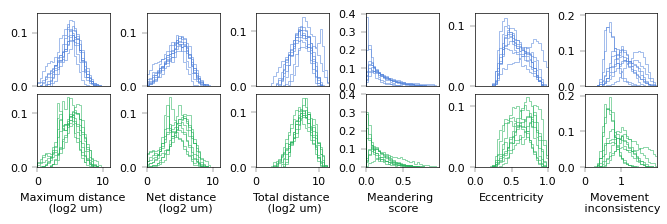

In [82]:
import seaborn as sns

d = pkl.load(open('data/tissue_metrics.pkl', 'rb'))

nrows = 2
ncols = len(d.keys())
offset = .000001

mnframe = 20

colors = {'Forebrain': "#5384db",
          'GBM': "#27b35d"}

samples = d['D_max'].keys()
sample2tissue = {'EV14': 'Forebrain', 'EV21': 'Forebrain', 'EV26': 'Forebrain', 'EV29': 'Forebrain', 
                 'EV31': 'Forebrain', 'EV32': 'Forebrain', 'EV34': 'Forebrain', 'EV36': 'Forebrain', 
                 'EV38': 'Forebrain', 'EV17': 'GBM', 'EV18': 'GBM', 'EV22': 'GBM', 'EV24': 'GBM', 
                 'EV25': 'GBM', 'EV30': 'GBM', 'EV33': 'GBM', 'EV37': 'GBM', 'EV39': 'GBM'
                }

ylabels = {'D_max': 'Maximum distance \n (log2 um)', 
           'D_net': 'Net distance \n (log2 um)', 
           'D_tot': 'Total distance \n (log2 um)',
           'Meandering': 'Meandering \n score',
           'Eccentricity': 'Eccentricity',
           'Movement_inconsistency': 'Movement \n inconsistency'}
modes = ['log2', 'log2', 'log2', 'linear', 'linear', 'linear']

w,h = 8,2
fig, ax = plt.subplots(nrows, ncols, figsize=(w,h))

for c, k in enumerate(d.keys()):
    current_mode = modes[c]

    if current_mode == 'log2':
        mx = np.log2(np.max(np.nan_to_num(np.hstack([d[k][id] for id in samples])))+offset)
    elif current_mode == 'linear':
        mx = np.max(np.nan_to_num(np.hstack([d[k][id] for id in samples])))
    
    for id in samples:

        if sample2tissue[id] == 'Forebrain':
            r = 0
        else:
            r = 1
            
        data = d[k][id]
        data = data[~np.isnan(data)]
        if current_mode == 'log2':
            ax[r,c].hist(np.log2(data+offset), color=colors[sample2tissue[id]], alpha=.75, bins=30, range=(0, mx), 
                         lw=.5, histtype='step', weights=1 / len(data) * np.ones(len(data)))
        elif current_mode == 'linear':
            ax[r,c].hist(data, color=colors[sample2tissue[id]], alpha=.75, bins=30, range=(0, mx), 
                         lw=.5, histtype='step', weights=1 / len(data) * np.ones(len(data)))

        if r != nrows-1:
            ax[r,c].set_xticks([])
        if r == nrows-1:
            ax[r,c].set_xlabel(ylabels[k], fontsize=8)

        ax[r,c].set(xlim=(0,mx))
        for axis in ['top','bottom','left','right']:
            ax[r,c].spines[axis].set_linewidth(0.5)

        ax[r,c].tick_params(axis='both', which='major', labelsize=8)


    ymx = np.max([axis.get_ylim()[-1] for axis in ax[:,c]])
    for axis in ax[:,c]:
        axis.set_ylim([0,ymx])
        axis.tick_params(axis='both', which='major', labelsize=8, width=.25)
        axis.set_yticks(np.arange(0,ymx,.1))
    
    plt.subplots_adjust(wspace=0.5, hspace=0.1)

## Lineage trees



In [124]:
import pandas as pd
samples = ['EV14_Region0000', 'EV21_Region0000', 'EV26_Region1',
        'EV29_Region1', 'EV31_Region1', 'EV31_Region2', 'EV32_Region1',
        'EV34_Region1', 'EV36_Region1', 'EV38_Region1',
        'EV17_Region0000', 'EV18_Region0000', 'EV18_Region0001',
        'EV18_Region0002', 'EV22_Region0000', 'EV22_Region0001',
        'EV22_Region0002', 'EV22_Region0003', 'EV22_Region0004',
        'EV22_Region0005', 'EV24_Region1', 'EV25_Region1', 'EV25_Region2',
        'EV30_Region1', 'EV30_Region2', 'EV30_Region3', 'EV33_Region1',
        'EV37_Region1', 'EV39_Region1']

counts = pkl.load(open('/date/sl/embryoscope/other/notebooks/embryoscope/paper_figures/data/counts.pkl', 'rb'))
samples2ids = {k:k.split('_')[0] for k in samples}
ids = [samples2ids[x] for x in samples]

totals = {}
for id, cnt in zip(ids, counts):
    vals = np.zeros(4)
    for i in [1,3,5,7]:
        if i in cnt:
            vals[int((i-1)/2)] = cnt[i]
    if id not in totals:
        totals[id] = vals
    else:
        totals[id] += vals

r, vals = [], []
for k in totals:
    vals.append(totals[k])
    r.append(k)

df_mitosis = pd.DataFrame(vals, dtype=int,  index = r, columns = [0,1,2,3])

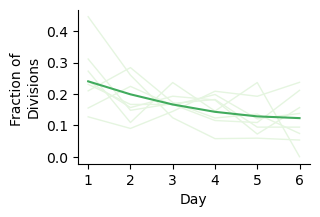

In [122]:
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection

## Division per day
num_bins = 6
bin_width = 96
day_div = {}

timepoints = pkl.load(open('data/division_points.pkl', 'rb'))

samples = ['EV17_Region0000', 'EV22_Region0000', 'EV22_Region0001',
        'EV22_Region0002', 'EV22_Region0003', 'EV22_Region0004',
        'EV22_Region0005', 'EV24_Region1', 'EV25_Region1', 'EV25_Region2',
        'EV30_Region2', 'EV30_Region3', 'EV33_Region1',
        'EV37_Region1', 'EV39_Region1']

samples2ids = {k:k.split('_')[0] for k in samples}
ids = [samples2ids[x] for x in samples]

for i, sample in enumerate(samples):
    id = sample.split('_')[0]

    Tp = timepoints[sample]
    hist, edges = np.histogram(
                Tp,
                bins=num_bins,
                range=(0, bin_width*num_bins),
                density=False)

    if id not in day_div:
        day_div[id] = hist
    else:
        day_div[id] = day_div[id] + hist

xb,yb = [],[]

fig,ax = plt.subplots(1,1, figsize=(3,2))
for i,k in enumerate(day_div):
    v = day_div[k]/np.sum(day_div[k])
    ax.plot(v, c=(0.8980392156862745, 0.9607843137254902, 0.8784313725490196, 1.0), lw=1);

    xb.append(np.arange(len(v)))
    yb.append(v)

xb,yb = [x for s in xb for x in s], [y for s in yb for y in s]
z = np.polyfit(xb, yb, 2)
p = np.poly1d(z)

#add trendline to plot
x = np.arange(np.max(xb)+1)
plt.plot(x, p(x), c=(0.2549019607843137, 0.6705882352941176, 0.36470588235294116, 1.0))

ax.set_ylabel('Fraction of \nDivisions')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Day')
ax.set_xticks(np.arange(num_bins), [str(i+1) for i in range(num_bins)])

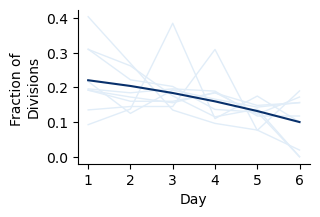

In [121]:
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection

## Division per day

## Division per day
num_bins = 6
bin_width = 96
day_div = {}

timepoints = pkl.load(open('data/division_points.pkl', 'rb'))

samples = ['EV14_Region0000', 'EV21_Region0000', 'EV26_Region1',
        'EV29_Region1', 'EV31_Region1', 'EV31_Region2', 'EV32_Region1',
        'EV34_Region1', 'EV36_Region1', 'EV38_Region1']

samples2ids = {k:k.split('_')[0] for k in samples}
ids = [samples2ids[x] for x in samples]

for i, sample in enumerate(samples):
    id = sample.split('_')[0]

    Tp = timepoints[sample]
    hist, edges = np.histogram(
                Tp,
                bins=num_bins,
                range=(0, bin_width*num_bins),
                density=False)

    if id not in day_div:
        day_div[id] = hist
    else:
        day_div[id] = day_div[id] + hist

xb,yb = [],[]

fig,ax = plt.subplots(1,1, figsize=(3,2))
for i,k in enumerate(day_div):
    v = day_div[k]/np.sum(day_div[k])
    ax.plot(v, c=(0.8814814814814815, 0.9285403050108932, 0.9721132897603486, 1.0), lw=1);

    xb.append(np.arange(len(v)))
    yb.append(v)

xb,yb = [x for s in xb for x in s], [y for s in yb for y in s]
z = np.polyfit(xb, yb, 2)
p = np.poly1d(z)

#add trendline to plot
x = np.arange(np.max(xb)+1)
plt.plot(x, p(x), c=(0.03137254901960784, 0.18823529411764706, 0.4196078431372549, 1.0))

ax.set_ylabel('Fraction of \nDivisions')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Day')
ax.set_xticks(np.arange(num_bins), [str(i+1) for i in range(num_bins)])

/var/lib/condor/execute/dir_1159735/ipykernel_47493/2378788086.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Greens', 5)
/var/lib/condor/execute/dir_1159735/ipykernel_47493/2378788086.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(np.arange(df_log.shape[0]), df_log[0], c=cmap(1))
/var/lib/condor/execute/dir_1159735/ipykernel_47493/2378788086.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case 

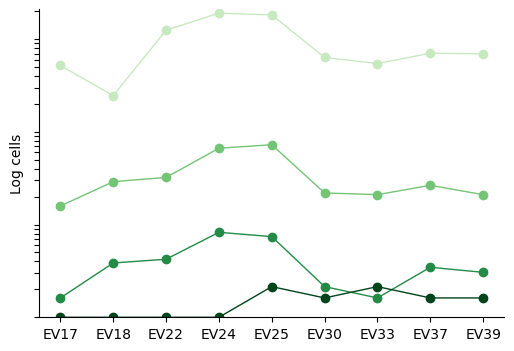

In [93]:
## GBM
from matplotlib import cm
lw = 1

cmap = cm.get_cmap('Greens', 5)

samples = ['EV17_Region0000', 'EV18_Region0000', 'EV18_Region0001',
        'EV18_Region0002', 'EV22_Region0000', 'EV22_Region0001',
        'EV22_Region0002', 'EV22_Region0003', 'EV22_Region0004',
        'EV22_Region0005', 'EV24_Region1', 'EV25_Region1', 'EV25_Region2',
        'EV30_Region1', 'EV30_Region2', 'EV30_Region3', 'EV33_Region1',
        'EV37_Region1', 'EV39_Region1']
samples2ids = {k:k.split('_')[0] for k in samples}
ids = [samples2ids[x] for x in samples]

df_GBM = df_mitosis.loc[np.unique(ids),:]
df_log = np.log(df_GBM + 1)

plt.figure(figsize=(df_log.shape[0]/1.5,4))
plt.plot(df_log[0], c=cmap(1), lw=lw)
plt.scatter(np.arange(df_log.shape[0]), df_log[0], c=cmap(1))
plt.plot(df_log[1], c=cmap(2), lw=lw)
plt.scatter(np.arange(df_log.shape[0]), df_log[1], c=cmap(2))
plt.plot(df_log[2], c=cmap(3), lw=lw)
plt.scatter(np.arange(df_log.shape[0]), df_log[2], c=cmap(3))
plt.plot(df_log[3], c=cmap(4), lw=lw)
plt.scatter(np.arange(df_log.shape[0]), df_log[3], c=cmap(4))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(np.log2(np.array([1,2,3,4,5,6,7,8,9,10,
                                20,30,40,50,60,70,80,90,100,
                                200,300,400,500,600,700,800,900,1000,2000])+.0001), [])
ax.set_ylim([np.log2(1), np.log2(2100)]);plt.ylabel('Log cells');

/var/lib/condor/execute/dir_1159735/ipykernel_47493/1132072288.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues', 5)
/var/lib/condor/execute/dir_1159735/ipykernel_47493/1132072288.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(np.arange(df_log.shape[0]), df_log[0], c=cmap(1))
/var/lib/condor/execute/dir_1159735/ipykernel_47493/1132072288.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case i

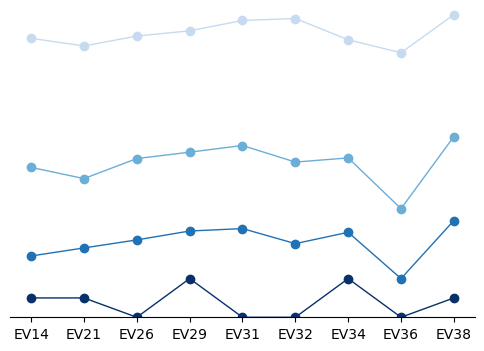

In [95]:
## GBM
lw = 1

cmap = cm.get_cmap('Blues', 5)

# samples = overview.ID[overview.Tissue=='Forebrain']
samples = ['EV14_Region0000', 'EV21_Region0000', 'EV26_Region1',
        'EV29_Region1', 'EV31_Region1', 'EV31_Region2', 'EV32_Region1',
        'EV34_Region1', 'EV36_Region1', 'EV38_Region1']
samples2ids = {k:k.split('_')[0] for k in samples}
ids = [samples2ids[x] for x in samples]

df_Forebrain = df_mitosis.loc[np.unique(ids),:]
df_log = np.log(df_Forebrain + 1)

plt.figure(figsize=(df_log.shape[0]/1.5,4))
plt.plot(df_log[0], c=cmap(1), lw=lw)
plt.scatter(np.arange(df_log.shape[0]), df_log[0], c=cmap(1))
plt.plot(df_log[1], c=cmap(2), lw=lw)
plt.scatter(np.arange(df_log.shape[0]), df_log[1], c=cmap(2))
plt.plot(df_log[2], c=cmap(3), lw=lw)
plt.scatter(np.arange(df_log.shape[0]), df_log[2], c=cmap(3))
plt.plot(df_log[3], c=cmap(4), lw=lw)
plt.scatter(np.arange(df_log.shape[0]), df_log[3], c=cmap(4))
plt.ylabel('Log cells');
ax = plt.gca()
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([np.log2(1), np.log2(2100)]);
plt.ylabel('Log cells');

## Wind plots

  0%|          | 0/2 [00:00<?, ?it/s]

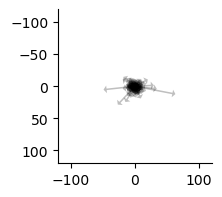

 50%|█████     | 1/2 [00:00<00:00,  6.20it/s]

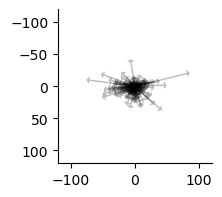

100%|██████████| 2/2 [00:00<00:00,  7.39it/s]


In [128]:
## Subset fixed scale

from tifffile import imread

grid_size=20
mnc = 10

samples = ['EV39', 'EV38']

for sample in tqdm(samples):
    disp = np.load(f'data/{sample}_displacement.npy')
    yx = np.load(f'data/{sample}_start.npy')
    
    with plt.ioff():
        # Create hexagonal bins
        hb_x = plt.hexbin(yx[:,1], yx[:,0], C=disp[:,1], gridsize=grid_size, reduce_C_function=np.mean, mincnt=mnc)
        hb_y = plt.hexbin(yx[:,1], yx[:,0], C=disp[:,0], gridsize=grid_size, reduce_C_function=np.mean, mincnt=mnc)
        
        # Retrieve hexagonal bin centers and displacement sums
        hex_centers = hb_x.get_offsets()
        binned_values_x = hb_x.get_array()
        binned_values_y = hb_y.get_array()
        
        # Combine the data into a list of (x, y, sum_disp_x, sum_disp_y)
        hex_data = np.array([
            (center[0], center[1], sum_x, sum_y)
            for center, sum_x, sum_y in zip(hex_centers, binned_values_x, binned_values_y)
        ])
    plt.close()
    
    plt.figure(figsize=(2,2))
    plt.quiver(np.zeros(hex_data.shape[0]), np.zeros(hex_data.shape[0]), 
               hex_data[:,2], hex_data[:,3],
               angles='xy', scale_units='xy', scale=1,
               width=.01, headwidth=5, headlength=2, headaxislength=2,
               color = 'Black', alpha=.25
              )
    
    mx = 120
    plt.xlim([-mx,mx])
    plt.ylim([mx,-mx])
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_aspect('equal')
    plt.show()

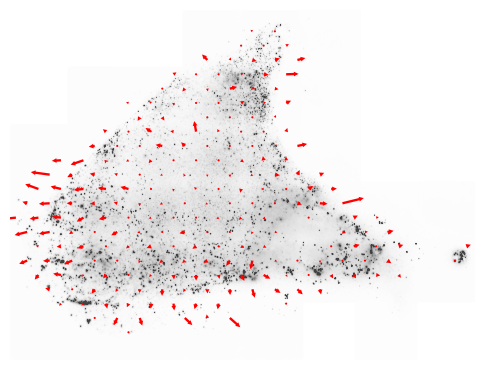

In [130]:
%matplotlib inline
import glob
import numpy as np
import matplotlib.pyplot as plt

grid_size=20
mnc = 10

from tifffile import imread
im = io.imread('data/EV39_last_timestep.tif')
bg_mask = im == np.min(im)
mn = np.min(im[~bg_mask])
im[bg_mask] = mn

disp = np.load(f'data/EV39_displacement.npy')
yx = np.load(f'data/EV39_start.npy')

with plt.ioff():
    # Create hexagonal bins
    hb_x = plt.hexbin(yx[:,1], yx[:,0], C=disp[:,1], gridsize=grid_size, reduce_C_function=np.mean, mincnt=mnc)
    hb_y = plt.hexbin(yx[:,1], yx[:,0], C=disp[:,0], gridsize=grid_size, reduce_C_function=np.mean, mincnt=mnc)
    
    # Retrieve hexagonal bin centers and displacement sums
    hex_centers = hb_x.get_offsets()
    binned_values_x = hb_x.get_array()
    binned_values_y = hb_y.get_array()
    
    # Combine the data into a list of (x, y, sum_disp_x, sum_disp_y)
    hex_data = np.array([
        (center[0], center[1], sum_x, sum_y)
        for center, sum_x, sum_y in zip(hex_centers, binned_values_x, binned_values_y)
    ])
plt.close()

plt.figure(figsize=(6,6))
plt.imshow(im, cmap='Greys', vmax=np.quantile(im.flatten(), .995), alpha=.75)
plt.axis('off')

plt.quiver(hex_data[:,0], hex_data[:,1], hex_data[:,2], hex_data[:,3],
           angles='xy', scale_units='xy', scale=.25,
           width=.005, headwidth=2, headlength=2, headaxislength=2,
           color = 'Red'
          )

(13007, 13006)


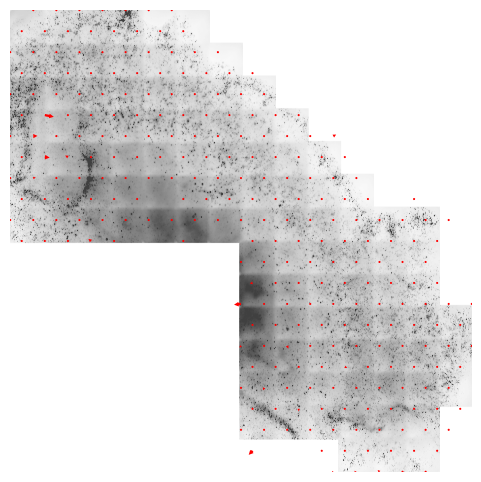

In [132]:
import numpy as np
import matplotlib.pyplot as plt

grid_size=20
mnc = 10

from tifffile import imread
im = imread(sorted(glob.glob('data/EV38_last_timestep.tif'))[-1])
bg_mask = im == np.min(im)
mn = np.min(im[~bg_mask])
im[bg_mask] = mn

disp = np.load(f'data/EV38_displacement.npy')
yx = np.load(f'data/EV38_start.npy')

with plt.ioff():
    # Create hexagonal bins
    hb_x = plt.hexbin(yx[:,1], yx[:,0], C=disp[:,1], gridsize=grid_size, reduce_C_function=np.mean, mincnt=mnc)
    hb_y = plt.hexbin(yx[:,1], yx[:,0], C=disp[:,0], gridsize=grid_size, reduce_C_function=np.mean, mincnt=mnc)
    
    # Retrieve hexagonal bin centers and displacement sums
    hex_centers = hb_x.get_offsets()
    binned_values_x = hb_x.get_array()
    binned_values_y = hb_y.get_array()
    
    # Combine the data into a list of (x, y, sum_disp_x, sum_disp_y)
    hex_data = np.array([
        (center[0], center[1], sum_x, sum_y)
        for center, sum_x, sum_y in zip(hex_centers, binned_values_x, binned_values_y)
    ])
plt.close()

plt.figure(figsize=(6,6))
plt.imshow(im, cmap='Greys', vmax=np.quantile(im.flatten(), .995), alpha=.75)
plt.axis('off')
print(im.shape)

plt.quiver(hex_data[:,0], hex_data[:,1], hex_data[:,2], hex_data[:,3],
           angles='xy', scale_units='xy', scale=.25,
           width=.005, headwidth=2, headlength=2, headaxislength=2,
           color = 'Red'
          )

## Lineage trees on tissue

/var/lib/condor/execute/dir_1159735/ipykernel_47493/391004520.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(valid_roots))


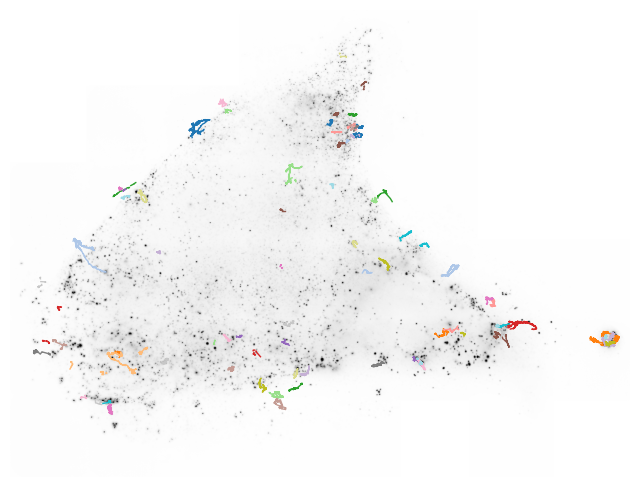

In [146]:
from collections import Counter
from matplotlib import cm
from tifffile import imread
im = imread(sorted(glob.glob('data/EV39_last_timestep.tif'))[-1])
bg_mask = im == np.min(im)
mn = np.min(im[~bg_mask])
im[bg_mask] = mn

tracks = np.load('data/EV39_tracks.npy')
df = pd.read_csv('data/EV39_metrics.csv', header=0)

x = Counter(df['Root'])
valid_roots = [k for k,v in x.items() if v > 1]
valid_cells = [i for i in range(tracks.shape[0]) if df['Root'][i] in valid_roots]

cmap = cm.get_cmap('tab20', len(valid_roots))
cols = [cmap(i) for i in range(len(valid_roots))]
colors = {k:v for k,v in zip(valid_roots, cols)}

plt.figure(figsize=(8,8))
plt.imshow(im, cmap='Greys')
plt.axis('off');

t = tracks.shape[-1]
for i in valid_cells:
    xy = tracks[i,:,:].reshape([2,t])
    valid = xy[1,:] > 0
    plt.plot(xy[1,valid], xy[0,valid], c=colors[df['Root'][i]], lw=1, alpha=1)

plt.ylim((im.shape[0],0))
plt.gca().set_aspect('equal')


/var/lib/condor/execute/dir_1159735/ipykernel_47493/114402668.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(valid_roots))


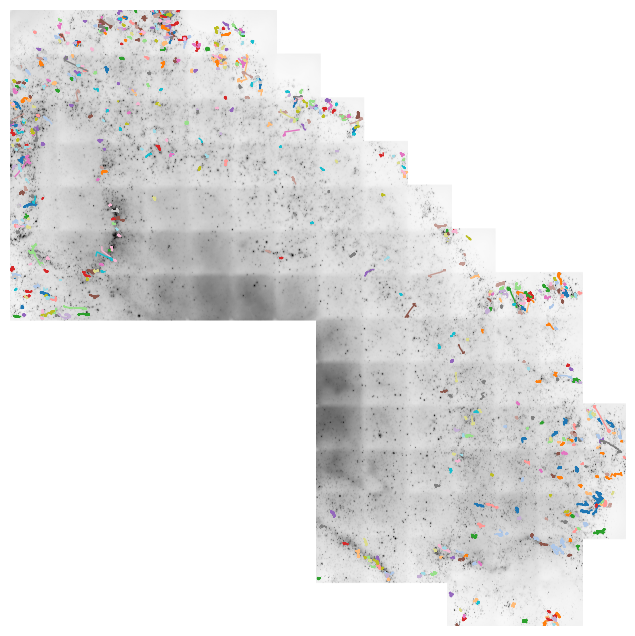

In [147]:
from collections import Counter
from matplotlib import cm
from tifffile import imread
im = imread(sorted(glob.glob('data/EV38_last_timestep.tif'))[-1])
bg_mask = im == np.min(im)
mn = np.min(im[~bg_mask])
im[bg_mask] = mn

tracks = np.load('data/EV38_tracks.npy')
df = pd.read_csv('data/EV38_metrics.csv', header=0)

x = Counter(df['Root'])
valid_roots = [k for k,v in x.items() if v > 1]
valid_cells = [i for i in range(tracks.shape[0]) if df['Root'][i] in valid_roots]

cmap = cm.get_cmap('tab20', len(valid_roots))
cols = [cmap(i) for i in range(len(valid_roots))]
colors = {k:v for k,v in zip(valid_roots, cols)}

plt.figure(figsize=(8,8))
plt.imshow(im, cmap='Greys')
plt.axis('off');

t = tracks.shape[-1]
for i in valid_cells:
    xy = tracks[i,:,:].reshape([2,t])
    valid = xy[1,:] > 0
    plt.plot(xy[1,valid], xy[0,valid], c=colors[df['Root'][i]], lw=1, alpha=1)

plt.ylim((im.shape[0],0))
plt.gca().set_aspect('equal')

## Model brownian motion

In [133]:
from math import sqrt
from scipy.stats import norm
import numpy as np


def brownian(x0, n, dt, delta, out=None):
    """
    Generate an instance of Brownian motion (i.e. the Wiener process):

        X(t) = X(0) + N(0, delta**2 * t; 0, t)

    where N(a,b; t0, t1) is a normally distributed random variable with mean a and
    variance b.  The parameters t0 and t1 make explicit the statistical
    independence of N on different time intervals; that is, if [t0, t1) and
    [t2, t3) are disjoint intervals, then N(a, b; t0, t1) and N(a, b; t2, t3)
    are independent.
    
    Written as an iteration scheme,

        X(t + dt) = X(t) + N(0, delta**2 * dt; t, t+dt)


    If `x0` is an array (or array-like), each value in `x0` is treated as
    an initial condition, and the value returned is a numpy array with one
    more dimension than `x0`.

    Arguments
    ---------
    x0 : float or numpy array (or something that can be converted to a numpy array
         using numpy.asarray(x0)).
        The initial condition(s) (i.e. position(s)) of the Brownian motion.
    n : int
        The number of steps to take.
    dt : float
        The time step.
    delta : float
        delta determines the "speed" of the Brownian motion.  The random variable
        of the position at time t, X(t), has a normal distribution whose mean is
        the position at time t=0 and whose variance is delta**2*t.
    out : numpy array or None
        If `out` is not None, it specifies the array in which to put the
        result.  If `out` is None, a new numpy array is created and returned.

    Returns
    -------
    A numpy array of floats with shape `x0.shape + (n,)`.
    
    Note that the initial value `x0` is not included in the returned array.
    """

    x0 = np.asarray(x0)

    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    r = norm.rvs(size=x0.shape + (n,), scale=delta*sqrt(dt))

    # If `out` was not given, create an output array.
    if out is None:
        out = np.empty(r.shape)

    # This computes the Brownian motion by forming the cumulative sum of
    # the random samples. 
    np.cumsum(r, axis=-1, out=out)

    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)

    return out

import numpy as np


def estimate_delta_from_tracks(tracks, dt):
    """
    Estimate delta from a set of Brownian motion tracks.

    Parameters:
        tracks: numpy array of shape (n_tracks, d, n_steps)
        dt: float, time step size

    Returns:
        delta_est: estimated delta value
    """
    n_tracks, d, n_steps = tracks.shape
    max_lag = n_steps // 2  # to reduce noise at large lags

    msd = np.zeros(max_lag)
    for lag in range(1, max_lag):
        displacements = tracks[:, :, lag:] - tracks[:, :, :-lag]
        squared_displacements = np.sum(displacements ** 2, axis=1)  # sum over dimensions
        msd[lag] = np.mean(squared_displacements)

    # Linear fit to MSD = delta^2 * d * tau
    tau = np.arange(max_lag) * dt
    slope, _ = np.polyfit(tau[1:], msd[1:], 1)  # skip lag 0
    delta_squared = slope / d
    delta = np.sqrt(delta_squared)

    return delta

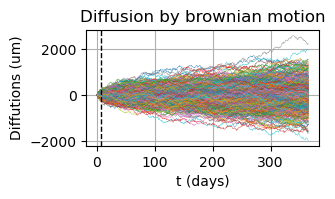

In [134]:
fig, ax = plt.subplots(1,1, figsize = (3,1.5))

# The Wiener process parameter.
delta = 3.29
# Total time.
T = 96 * 365
# Number of steps.
N = 1000
# Time step size
dt = T/N
# Number of realizations to generate.
m = 500
# Create an empty array to store the realizations.
x = np.empty((m,N+1))
# Initial values of x.
x[:, 0] = 0

brownian(x[:,0], N, dt, delta, out=x[:,1:])

t = np.linspace(0.0, N*dt, N+1)
t_plot = t / 96
for k in range(m):
    ax.plot(t_plot, x[k], lw=.25)
ax.set_xlabel('t (days)')
ax.set_ylabel('Diffutions (um)')
ax.set_title('Diffusion by brownian motion')
ax.grid(True)
ax.axvline(7, ls='--',c='black', lw=1)
